# Classes

In this notebook we will research the influence of the amount of imbalanced classes of the classifier problem on active learning.

In [12]:
## Imports ##

import numpy as np

# matplotlib
import matplotlib as mlp
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# skactiveml
from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling
from skactiveml.pool import RandomSampling
from skactiveml.utils import MISSING_LABEL

# accuracy
from balanced_accuracy import balanced_accuracy
from plot_accuracy import plot_accuracy

# set warnings
import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

In [13]:
# Generate the data
def get_data(n_samples=100, n_classes=2, weights=None, random_state=None):
    """ Creates 2 data sets, one for training, one for testing

    Returns 4-tuple:
    - Xf (array like) List of the samples for training.
    - Xt (array like) List of the samples for testing. 
    - yf (array like) List of the labels for training. 
    - yt (array like) List of the labels for testing.
    """

    X, y = make_classification(
        n_samples=n_samples,
        n_classes=n_classes,
        weights=weights,
        random_state=random_state,
        n_features=n_classes,
        n_informative=n_classes,
        n_redundant=0
        )
    return train_test_split(X, y, random_state=random_state)


In [14]:
# perform the active learning cycle
def get_accuracy(n_samples=800, n_classes=2, weights=None, cycles=100, al=True, nn=False):
    dat = []
    for rand in range(10):
        Xf, Xt, yf, yt = get_data(n_samples=n_samples, n_classes=n_classes, weights=weights, random_state=rand)
        y = np.full(shape=yf.shape, fill_value=MISSING_LABEL)
        clf = SklearnClassifier(MLPClassifier(), classes=np.unique(yf)) if nn else SklearnClassifier(LogisticRegression(), classes=np.unique(yf))
        qs = UncertaintySampling(random_state=rand) if al else RandomSampling(random_state=rand)

        out = []

        clf.fit(Xf, y)
        for _ in range(cycles):
            i = qs.query(Xf, y, clf) if al else qs.query(Xf, y)
            y[i] = yf[i]
            clf.fit(Xf, y)

            # predict the labels
            y_predict = clf.predict(Xt)
            # get the balanced accuracy
            out.append(balanced_accuracy(yt, y_predict))
        dat.append(out)

    return np.mean(np.array(dat), axis=0)


Since we use imbalanced data we have to ensure that the classes don't have the same size.
Here we generate the weights of the classes. Each class is dubble the size of the next one.

In [15]:
def class_weights(n_classes):
    # Generate the first element in the list
    first_element = 1
    
    # Initialize the list with the first element
    percentages = [first_element]
    
    # Generate the subsequent elements, each roughly half the size of the previous one
    for _ in range(n_classes - 1):
        next_element = percentages[-1] * 0.5
        percentages.append(next_element)
    
    # Normalize to ensure the sum is equal to 1
    total_sum = sum(percentages)
    percentages = [element / total_sum for element in percentages]
    return percentages

In [16]:
for i in range(1, 7):
    print(f'{i}: {class_weights(i)}')

1: [1.0]
2: [0.6666666666666666, 0.3333333333333333]
3: [0.5714285714285714, 0.2857142857142857, 0.14285714285714285]
4: [0.5333333333333333, 0.26666666666666666, 0.13333333333333333, 0.06666666666666667]
5: [0.5161290322580645, 0.25806451612903225, 0.12903225806451613, 0.06451612903225806, 0.03225806451612903]
6: [0.5079365079365079, 0.25396825396825395, 0.12698412698412698, 0.06349206349206349, 0.031746031746031744, 0.015873015873015872]


In [17]:
# perform random sampling for different class sizes
dataR = []
for n_classes in range(2,7):
    dataR.append(
        (get_accuracy(n_classes=n_classes, weights=class_weights(n_classes=n_classes), al=False),
         f'{n_classes} classes')
        )

In [18]:
# perform uncertainty sampling for different class sizes
dataU = []
for n_classes in range(2,7):
    dataU.append(
        (get_accuracy(n_classes=n_classes, weights=class_weights(n_classes=n_classes), al=True),
         f'{n_classes} classes')
        )

In [19]:
# perform uncertainty sampling for different class sizes with a neural network
dataN = []
for n_classes in range(2,7):
    dataN.append(
        (get_accuracy(n_classes=n_classes, weights=class_weights(n_classes=n_classes), al=True, nn=True),
         f'{n_classes} classes')
        )

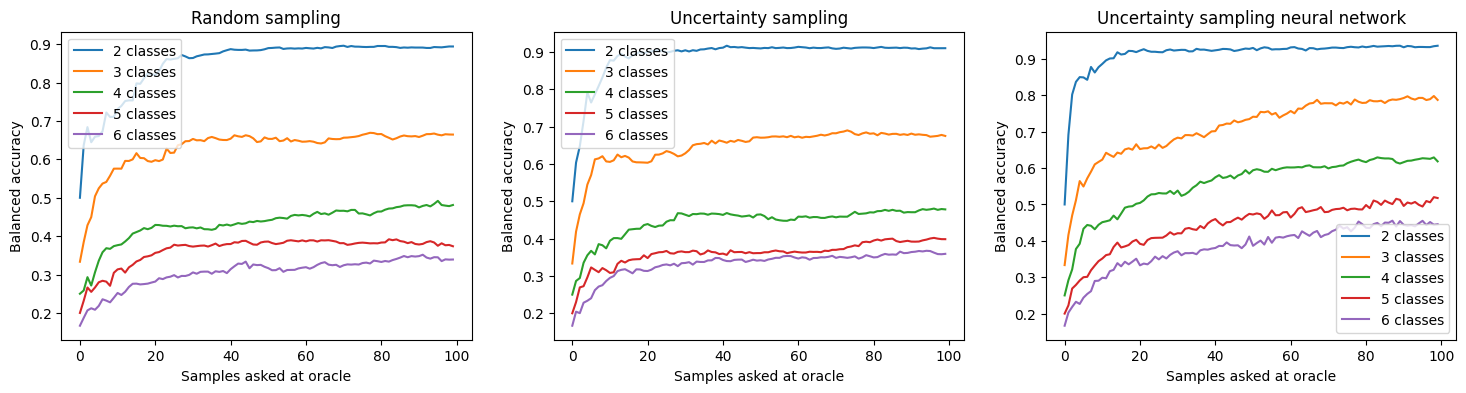

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

plot_accuracy('Random sampling', dataR, axs[0])
plot_accuracy('Uncertainty sampling', dataU, axs[1])
plot_accuracy('Uncertainty sampling neural network', dataN, axs[2])

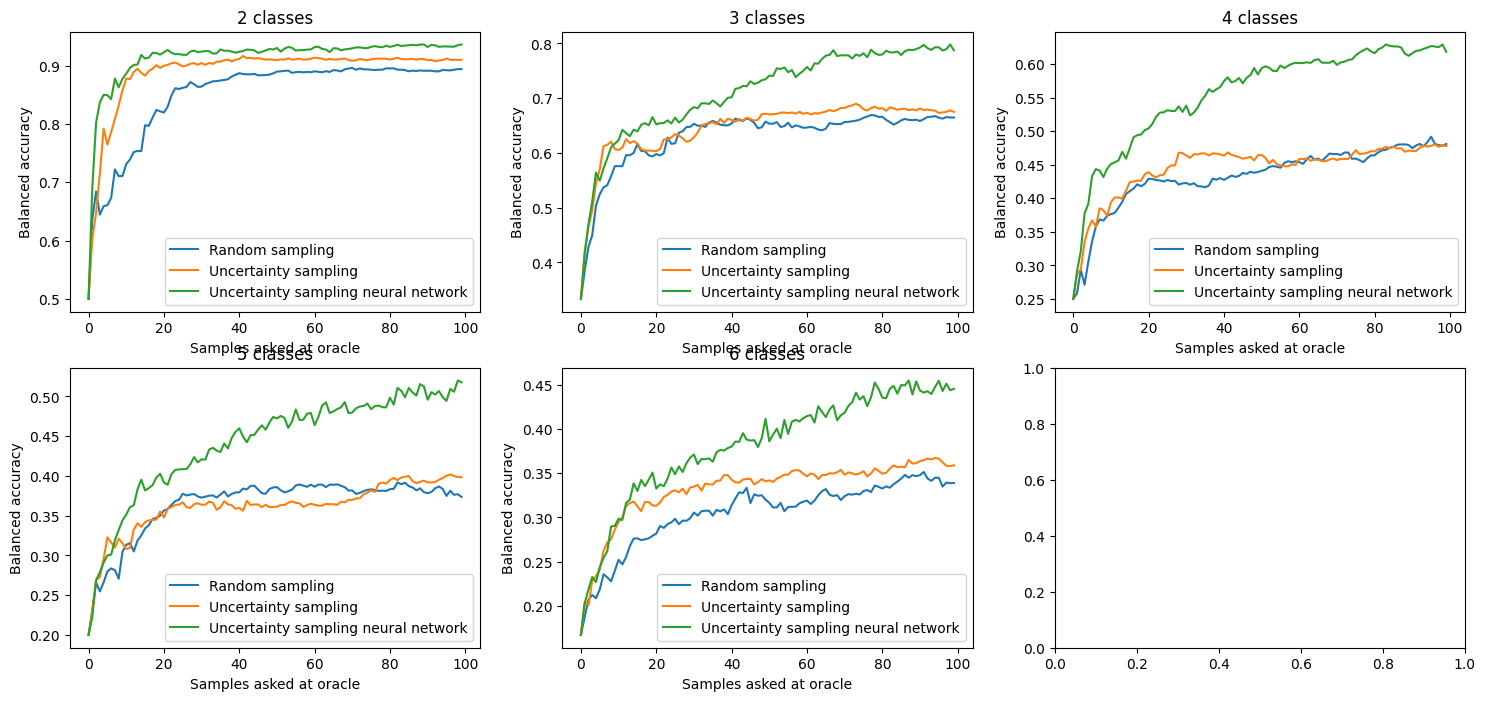

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

for i in range(len(dataR)):
    plot_data = [(dataR[i][0], 'Random sampling'),
    (dataU[i][0], 'Uncertainty sampling'),
    (dataN[i][0], 'Uncertainty sampling neural network')]

    plot_accuracy(dataR[i][1], plot_data, axs[i // 3, i % 3])